# Drop-in systems

Biorefinery systems can be created by connecting smaller systems, allowing us to create alternative configurations with ease. 

### System factories

This section is just to get you familiar with [SystemFactory](../process_tools/SystemFactory.txt) objects. Don’t worry if you don’t fully understand. The main idea is that SystemFactory objects return a System object when called and have a signature of `f(ID=None, ins=None, outs=None, *args, **kwargs)`, where the system `ID` is a string, `ins` are the inlet streams, and `outs` are the outlet streams (similar to unit operations). You can therefore call a SystemFactory object without any parameters. Let's first have a look at some of the system factories in the [biorefineries.sugarcane](https://github.com/BioSTEAMDevelopmentGroup/Bioindustrial-Park/tree/master/BioSTEAM%202.x.x/biorefineries/sugarcane) library:  

In [1]:
# Import system factories
from biorefineries.sugarcane import (
    create_juicing_system,
    create_sucrose_to_ethanol_system 
)
create_juicing_system.show(); print(); create_sucrose_to_ethanol_system.show() 

SystemFactory(
    f=<function create_juicing_system at 0x0000021F58909F70>,
    ID='juicing_sys',
    ins=[dict(ID='sugarcane',
              Glucose=4027.0413874,
              Lignin=10921.788510199998,
              Solids=5000.01,
              Sucrose=45639.757946000005,
              Ash=2000.0040000000001,
              Cellulose=20384.4074354,
              Hemicellulose=12027.357388,
              Water=233333.8,
              units='kg/hr',
              price=0.03455),
         dict(ID='enzyme',
              Cellulose=100,
              Water=900,
              units='kg/hr',
              price=0.5),
         dict(ID='H3PO4',
              H3PO4=74.23,
              Water=13.1,
              units='kg/hr',
              price=0),
         dict(ID='lime',
              CaO=333.0,
              Water=2200.0,
              units='kg/hr',
              price=0.077),
         dict(ID='polymer',
              Flocculant=0.83,
              units='kg/hr',
              price=0)]

[SystemFactory](../process_tools/SystemFactory.txt) objects have a predefined system `ID` and use keyword arguments to generate default `ins` and `outs` for the system. Hopefully things will be become clearer as we start to use system factories in the following sections…

### Using drop-in systems

As an example, here we create a sugarcane to ethanol production system without facilities (e.g., cooling tower, boiler) by using system factories:

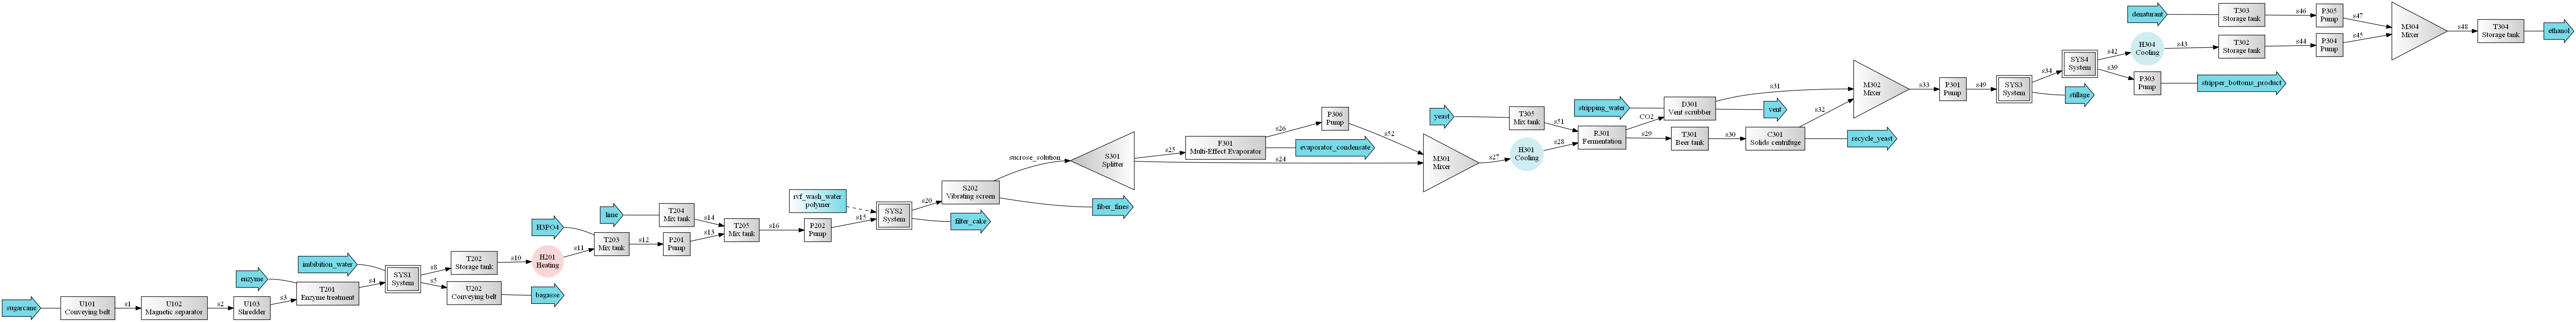

Stream: ethanol from <StorageTank: T304>
 phase: 'l', T: 339.27 K, P: 101325 Pa
 flow (kmol/hr): Water    10.4
                 Ethanol  489
                 Octane   4.38


In [2]:
from biorefineries.sugarcane import chemicals
from biosteam import Stream, settings, main_flowsheet

settings.set_thermo(chemicals)
sucrose_solution = Stream('sucrose_solution')
denaturant = Stream('denaturant',
                    Octane=230.69,
                    units='kg/hr',
                    price=0.756)
enzyme = Stream('enzyme',
                Cellulose=100,
                Water=900,
                units='kg/hr',
                price=0.5)

juicing_sys = create_juicing_system(
    ins=[None, enzyme], # Place enzyme in the 1st inlet (sugarcane and all other inlets are defaulted)
    outs=[sucrose_solution], # Place sucrose_solution at the 0th outlet (all others are defaulted)
) 
sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(ins=[sucrose_solution, denaturant]) 

# Here are a couple of other ways to connect systems:
#   Manually:
#   >>> sucrose_to_ethanol_sys.ins[0] = juicing_sys.outs[0]
#   With -pipe- notation:
#   >>> juicing_sys-0-0-sucrose_to_ethanol_sys 

# Connect systems, create a new system, and simulate
sugarcane_to_ethanol_system = main_flowsheet.create_system('sugarcane_to_ethanol_system')
sugarcane_to_ethanol_system.simulate()
sugarcane_to_ethanol_system.diagram()
sucrose_to_ethanol_sys.outs[0].show()

Let's have a look at all the inlets and outlets of the new system:

In [3]:
sugarcane_to_ethanol_system.show(data=False)

System: sugarcane_to_ethanol_system
ins...
[0] sugarcane
[1] imbibition_water
[2] enzyme
[3] rvf_wash_water
[4] H3PO4
[5] lime
[6] polymer
[7] stripping_water
[8] denaturant
[9] yeast
outs...
[0] filter_cake
[1] fiber_fines
[2] bagasse
[3] recycle_yeast
[4] vent
[5] evaporator_condensate
[6] stillage
[7] stripper_bottoms_product
[8] ethanol


The number of inlets (9) and outlets (10) are rather large. It may be helpful to specify what inlets and outlets do we want to expose:

In [4]:
ins = sugarcane_to_ethanol_system.ins
outs = sugarcane_to_ethanol_system.outs
sugarcane_to_ethanol_system.load_inlet_ports([ins[0], ins[8]])
sugarcane_to_ethanol_system.load_outlet_ports([outs[8], outs[2]])
sugarcane_to_ethanol_system.show(data=False)

System: sugarcane_to_ethanol_system
ins...
[0] sugarcane
[1] denaturant
outs...
[0] ethanol
[1] bagasse


### Making system factories

Create a SystemFactory object for creating sugarcane to ethanol systems: 

In [5]:
from biosteam import System, SystemFactory

@SystemFactory(
    ID='sugarcane_to_ethanol_sys',
    ins=[create_juicing_system.ins[0],
         create_sucrose_to_ethanol_system.ins[1]],
    outs=[create_sucrose_to_ethanol_system.outs[0],
          create_juicing_system.outs[1]]
)
def create_sugarcane_to_ethanol_system(ID, ins, outs):
    sugarcane, denaturant = ins
    ethanol, bagasse = outs
    juicing_sys = create_juicing_system(ins=sugarcane, outs=[None, bagasse]) # None will default to a stream
    sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(ins=(juicing_sys-0, denaturant), outs=ethanol)
    # If no system is returned, the system factory builds one from units created by the function

create_sugarcane_to_ethanol_system.show()

SystemFactory(
    f=<function create_sugarcane_to_ethanol_system at 0x0000021F58BADB80>,
    ID='sugarcane_to_ethanol_sys',
    ins=[dict(ID='sugarcane',
              Glucose=4027.0413874,
              Lignin=10921.788510199998,
              Solids=5000.01,
              Sucrose=45639.757946000005,
              Ash=2000.0040000000001,
              Cellulose=20384.4074354,
              Hemicellulose=12027.357388,
              Water=233333.8,
              units='kg/hr',
              price=0.03455),
         dict(ID='denaturant',
              Octane=230.69,
              units='kg/hr',
              price=0.756)],
    outs=[dict(ID='ethanol',
               price=0.789),
          dict(ID='bagasse')]
)


Create the sugarcane to ethanol system and simulate:

In [6]:
sugarcane_to_ethanol_sys = create_sugarcane_to_ethanol_system()
sugarcane_to_ethanol_sys.simulate()
sugarcane_to_ethanol_sys.show()

System: sugarcane_to_ethanol_sys
ins...
[0] sugarcane
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water          1.3e+04
                    Glucose        22.4
                    Sucrose        133
                    Ash            2e+03
                    Cellulose      126
                    Hemicellulose  81.2
                    Lignin         71.8
                    ...
[1] denaturant
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Octane  4.38
outs...
[0] ethanol
    phase: 'l', T: 339.27 K, P: 101325 Pa
    flow (kmol/hr): Water    10.4
                    Ethanol  489
                    Octane   4.38
[1] bagasse
    phase: 'l', T: 326.74 K, P: 101325 Pa
    flow (kmol/hr): Water          2.85e+03
                    Glucose        1.01
                    Sucrose        6.03
                    Ash            1.94e+03
                    Cellulose      123
                    Hemicellulose  78.8
                    Lignin         69.7
    

The [biorefineries](https://github.com/BioSTEAMDevelopmentGroup/Bioindustrial-Park) library has yet to fully implement SystemFactory objects across all functions that create systems, but that is the goal.